In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import spartan.utils.utils as spartan_utils
from imitation_agent.dataset.function_factory import ObservationFunctionFactory, ActionFunctionFactory
from imitation_agent.dataset.imitation_episode_sequence_dataset import ImitationEpisodeSequenceDataset
from imitation_agent.dataset.imitation_episode_dataset import ImitationEpisodeDataset
spartan_source_dir = spartan_utils.getSpartanSourceDir()
logs_config_yaml = os.path.join(spartan_source_dir, "modules/imitation_agent/config/task/move_to_box_0710_box_in_frame.yaml")
logs_config = spartan_utils.getDictFromYamlFilename(logs_config_yaml)

imitation_src_dir = os.path.join(spartan_source_dir, "modules/imitation_agent")
data_dir = spartan_utils.get_data_dir()
logs_dir_path = os.path.join(data_dir, "pdc/imitation/move_to_box_0710")

config_yaml = os.path.join(imitation_src_dir, "experiments", "01", "01_mlp_stateless_position.yaml")
config = spartan_utils.getDictFromYamlFilename(config_yaml)
config["use_gt_object_pose"] = True
config["use_vision"] = True

obs_function = ObservationFunctionFactory.get_function(config)
action_function = ActionFunctionFactory.action_from_config(config)
dataset = ImitationEpisodeDataset(logs_dir_path, logs_config, config,
                                  action_function=action_function,
                                  observation_function=obs_function)

loading logs...
Using SpartanDataset:
   - in train mode
   - number of scenes 1
   - total images:     0


01-gt-pose
is name in folder_to_plot_name gt-pose
03-gt-3D-points-projected
is name in folder_to_plot_name gt-3D-points-projected
04-dsae
is name in folder_to_plot_name dsae
05-endtoend
05-endtoend-full-image
is name in folder_to_plot_name endtoend-full-image
05-endtoend-full-image-seed1337
06-dd-d_images-SURF-16-10D
is name in folder_to_plot_name dd-d_images-SURF-16-10D
100
86
99
85
99
86
100
86
100
86
86
85
86
86
86


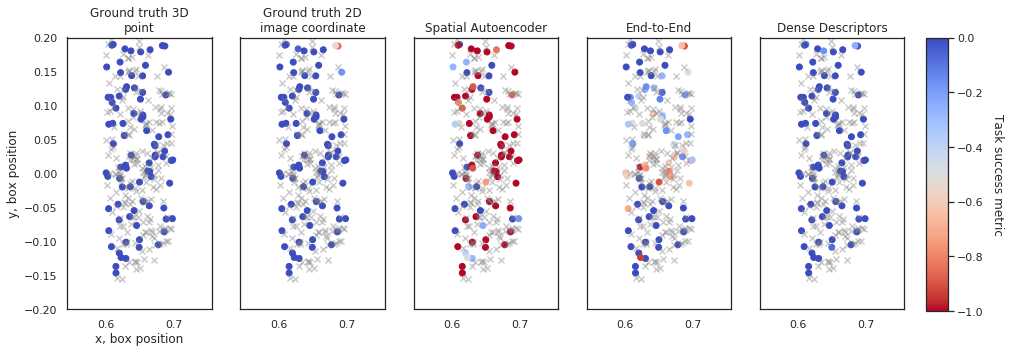

In [10]:
from matplotlib  import cm
sns.set(style="white")

def get_min_max_rewards(df):
    first = True
    for index, row in df.iterrows():
        if first:
            min_r = row["reward"]
            max_r = row["reward"]
            first = False
            continue
        if row["reward"] > max_r:
            max_r = row["reward"]
        if row["reward"] < min_r:
            min_r = row["reward"]
    return min_r, max_r
        
def get_normed_reward(reward, min_r, max_r):
    return (reward - min_r)/(max_r-min_r)
        

from spartan.utils import transformations
from imitation_agent.utils.visibility_utils import check_sugar_box_in_frame

def prune_out_of_FOV(df, dataset):
    # these don't move
    episode = dataset.episodes[dataset.episodes.keys()[0]]
    camera_num = 0
    T_W_camera = episode.get_camera_pose_matrix(camera_num)
    K = episode.get_K_matrix(camera_num)
    
    in_frame_list = []
    for index, row in df.iterrows():
        object_position = row["object_position"].strip("[").strip("]").split(",")
        object_position = [float(x) for x in object_position]
        object_position = np.asarray(object_position)
            
        static_rotation_only = transformations.euler_matrix(0.0, 0.0, 1.57, axes='sxyz')
        static_rotation_only[0,3] = object_position[0]
        static_rotation_only[1,3] = object_position[1]
        static_rotation_only[2,3] = 2.00476981e-02
        T_W_B = static_rotation_only
        in_frame = check_sugar_box_in_frame(K, T_W_camera=T_W_camera, T_W_B=T_W_B, urange=[0,640], vrange=[0,480])
        
        if not in_frame:
            in_frame_list.append(False)
        else:
            in_frame_list.append(True)
    
    df["in_frame"] = in_frame_list
    print len(df)
    print len(df[df["in_frame"] == True])
    return df[df["in_frame"] == True]

def adjust_reward(df):
    df['reward'] += 1.2
    df['reward'] = np.minimum(0.0,df['reward'])
    return df
    #reward = row["reward"]
    #reward += 1.2
    #reward = min(reward,0.0)
    
from textwrap import wrap
    
def create_distribution_plots(ax, df, dataset, min_r, max_r, first):
    
    xs = []
    ys = []
    cs = []
    
    # plot heatmap
    for index, row in df.iterrows():
        object_position = row["object_position"].strip("[").strip("]").split(",")
        object_position = [float(x) for x in object_position]
        object_position = np.asarray(object_position)
                    
            
        reward = row["reward"]
        #jet = cm.get_cmap("jet")
        #jet = cm.get_cmap("coolwarm")
        #normed_reward = (-1.0*get_normed_reward(reward, min_r, max_r))+1.0
        #normed_reward = get_normed_reward(reward, min_r, max_r)
        xs.append(object_position[0])
        ys.append(object_position[1])
        #cs.append(jet(normed_reward))
        cs.append(reward)
    [xs, ys, cs] = [np.asarray(x) for x in [xs,ys,cs]]
    
    hm = ax.scatter(xs, ys, c=cs, vmin=-1.0, vmax=0.0, cmap = cm.coolwarm_r)
    #hm = ax.scatter(ys, xs, c=cs, cmap = cm.coolwarm_r)
    #plt.colorbar(hm)
            
    # plot training examples
    for log_name in dataset.episodes.keys():
        episode = dataset.episodes[log_name]
        object_pose_trained = episode.sim_config_dict["instances"][0]["q0"]
        sc = ax.scatter(object_pose_trained[0], object_pose_trained[1], c="gray", alpha=0.4, marker="x")
    
    ax.axis('equal')
    ax.set(ylim=(-0.2, 0.2), xlim=(0.6, 0.7))
    ax.set_title("\n".join(wrap(row['name'],20)))
    #"\n".join(wrap("Some really really long long long title I really really need - and just can't - just can't - make it any - simply any - shorter - at all.", 60))
    if not first:
        #ax.set_xticks([])
        ax.set_yticks([])
    else:
        ax.set_ylabel("y, box position")
        ax.set_xlabel("x, box position")
    return hm
    
        
dfs = []  

def folder_to_plot_name(name):
    print "is name in folder_to_plot_name", name
    if name == "gt-pose":
        return "Ground truth 3D point"
    if name == "gt-3D-points-projected":
        return "Ground truth 2D image coordinate"
    if name == "dsae":
        return "Spatial Autoencoder"
    if name == "endtoend-full-image":
        return "End-to-End"
    if name == "dd-d_images-SURF-16-10D":
        return "Dense Descriptors"
    print name, "why no match?"
    return ValueError("didnt match!")

folders = []
for folder in sorted(os.listdir(os.path.join(spartan_source_dir, "sandbox/experiment_01/logs-200"))):
    print folder
    if folder == "05-endtoend" or "seed" in folder:
        continue
    folders.append(folder)
    path_to_move_to_box_folder = os.path.join(spartan_source_dir, "sandbox","experiment_01/logs-200",folder)
    path_to_csv = os.path.join(path_to_move_to_box_folder, "results.csv")
    df = pd.read_csv(path_to_csv, index_col=0)
    df["name"] = folder_to_plot_name(folder[3:])
    dfs.append(df)
    

for i, df in enumerate(dfs):
    dfs[i] = prune_out_of_FOV(df, dataset)
    
for i, df in enumerate(dfs):
    dfs[i] = adjust_reward(df)
    
    
min_r = 1e6
max_r = -1e6
for df in dfs:
    this_min, this_max = get_min_max_rewards(df)
    if this_min < min_r:
        min_r = this_min
    if this_max > max_r:
        max_r = this_max
        
# SETTING THIS MANUALLY FOR SCALE
min_r = -3

fig, axes = plt.subplots(ncols=len(dfs),nrows=1)
fig.set_figheight(5)
fig.set_figwidth(15)
for i, df in enumerate(dfs):
    ax = axes[i]
    if i == 0:
        first = True
    else:
        first = False
    print len(df)
    hm = create_distribution_plots(ax, df, dataset, min_r, max_r, first=first)
#plt.colorbar(hm, pad=0.2)

cbaxes = fig.add_axes([0.92, 0.12, 0.02, 0.76]) 
cb = plt.colorbar(hm, cax = cbaxes) 
cb.set_label('Task success metric', labelpad=20, rotation=270)

fig.savefig("MTB-spatialdistribution-1.0.pdf")

plt.show()

called plot
is name in folder_to_plot_name gt-pose
is name in folder_to_plot_name gt-3D-points-projected
is name in folder_to_plot_name dsae
is name in folder_to_plot_name endtoend-full-image
is name in folder_to_plot_name dd-d_images-SURF-16-10D


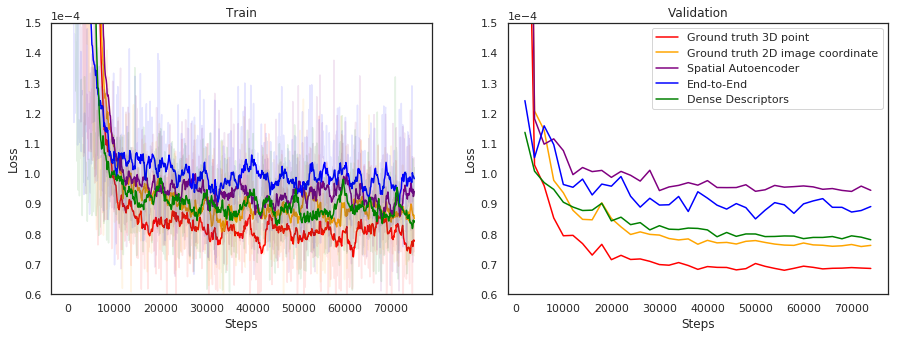

In [13]:
import numpy as np
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

import matplotlib as mpl
import matplotlib.pyplot as plt

def plot_tensorflow_log(axes, path, color, label, yes_train):

    event_acc = EventAccumulator(path)#, tf_size_guidance)
    event_acc.Reload()

    # Show all tags in the log file
    #print(event_acc.Tags())

    training_accuracies =   event_acc.Scalars('loss')
    validation_accuracies = event_acc.Scalars('test_loss_average')

    x_train_steps = []
    x_train_values = []
    
    
    for i in xrange(len(training_accuracies)):
        x_train_steps.append(training_accuracies[i][1]) # 1 is step
        x_train_values.append(training_accuracies[i][2]) # 2 is step
    
#     from scipy.signal import savgol_filter
#     x_train_values_filt = savgol_filter(x_train_values, 21, 2)

    #from scipy.signal import medfilt
    #x_train_values_filt = medfilt(x_train_values, 21)
    
    w = 0.90
    x_train_values = np.asarray(x_train_values)
    x_train_values_filt = x_train_values*0.0
    x_train_values_filt[0] = x_train_values[0]
    for i, v in enumerate(x_train_values[1:]):
        x_train_values_filt[i+1] = x_train_values_filt[i]*w + (1-w)*x_train_values[i]
   
    
#     from scipy import signal
#     xn = x_train_values
#     b, a = signal.butter(3, 0.05)
#     zi = signal.lfilter_zi(b, a)
#     z, _ = signal.lfilter(b, a, xn, zi=zi*xn[0])
#     z2, _ = signal.lfilter(b, a, z, zi=zi*z[0])
#     y = signal.filtfilt(b, a, xn)
#     x_train_values_filt = y

        
    x_validation_steps = []
    x_validation_values = []
    
    for i in xrange(len(validation_accuracies)):
        x_validation_steps.append(validation_accuracies[i][1])
        x_validation_values.append(validation_accuracies[i][2])
        

    if yes_train:
        axes[0].plot(np.asarray(x_train_steps), np.asarray(x_train_values_filt), color=color, label=label, alpha=1.0)
        axes[0].plot(np.asarray(x_train_steps), np.asarray(x_train_values), color=color, alpha=0.1)
    axes[1].plot(np.asarray(x_validation_steps), np.asarray(x_validation_values), label=label, color=color)

    axes[0].set_xlabel("Steps")
    axes[1].set_xlabel("Steps")
    axes[0].set_ylabel("Loss")
    axes[1].set_ylabel("Loss")
    axes[0].set_title("Train")
    axes[0].set(ylim=(0.6e-4, 1.5e-4))
    axes[1].set(ylim=(0.6e-4, 1.5e-4))
    axes[1].set_title("Validation")


def get_tf_events_file(path):
    return sorted(os.listdir(path))[-1]
    
base = os.path.join(data_dir, "pdc/imitation/trained_models/mlp_position/experiment_01-aug12-logs-200")

fig, axes = plt.subplots(ncols=2,nrows=1)
fig.set_figheight(5)
fig.set_figwidth(15)



#colors = ["black", "red", "orange", "green", "blue", "purple"]
colors = ["red", "orange", "purple", "blue", "green"]

#folders.insert(0,"00-blind")
#folders.remove("00-blind")

def plot_train_test(yes_train):
    print "called plot"
    counter = 0
    for color, folder in zip(colors, folders):
        counter+=1
        path_to = os.path.join(base,folder,"tensorboard")
        tf_file = get_tf_events_file(path_to)
        tf_file_full = os.path.join(path_to, tf_file)
        plot_tensorflow_log(axes, tf_file_full, color, label=folder_to_plot_name(folder[3:].split("-seed")[0]), yes_train=yes_train)
    #     if counter == 2:
    #         break

plot_train_test(yes_train=True)

# for seed_match in ["seed2", "seed3", "seed4", "seed1337"]:
#     folders = []
#     for folder in sorted(os.listdir(os.path.join(spartan_source_dir, "sandbox/experiment_01/logs-200"))):
#         if (folder == "05-endtoend") or (not folder.find("seed")) or ("dsae" in folder):
            
#             continue
#         folders.append(folder)
#         path_to_move_to_box_folder = os.path.join(spartan_source_dir, "sandbox","experiment_01/logs-200",folder)
#         #path_to_csv = os.path.join(path_to_move_to_box_folder, "results.csv")
#         #df = pd.read_csv(path_to_csv, index_col=0)
#         folder_name = folder[3:].split("-seed")[0]
#         df["name"] = folder_to_plot_name(folder_name)
#         dfs.append(df)
#     plot_train_test()

    
axes[0].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
axes[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.legend(loc='upper right', frameon=True)

# folders = ['01-gt-pose-seed2', '03-gt-3D-points-projected-seed2', '04-dsae', '05-endtoend-full-image-seed2', '06-dd-d_images-SURF-16-10D-seed2']
# plot_train_test(yes_train=False)

# folders = ['01-gt-pose-seed3', '03-gt-3D-points-projected-seed3', '04-dsae', '05-endtoend-full-image-seed3', '06-dd-d_images-SURF-16-10D-seed3']
# plot_train_test(yes_train=False)

# folders = ['01-gt-pose-seed4', '03-gt-3D-points-projected-seed4', '04-dsae', '05-endtoend-full-image-seed4', '06-dd-d_images-SURF-16-10D-seed4']
# plot_train_test(yes_train=False)

# folders = ['01-gt-pose-seed1337', '03-gt-3D-points-projected-seed1337', '04-dsae', '05-endtoend-full-image-seed1337', '06-dd-d_images-SURF-16-10D-seed1337']
# plot_train_test(yes_train=False)

fig.savefig("MTB-traintest.pdf")


plt.show()


In [4]:
print "Training times"
print "---------------"
import datetime

for folder in folders:
    path_to = os.path.join(base,folder,"tensorboard")
    tf_file = get_tf_events_file(path_to)
    tf_file_full = os.path.join(path_to, tf_file)
    event_acc = EventAccumulator(tf_file_full)#, tf_size_guidance)
    event_acc.Reload()
    training_accuracies =   event_acc.Scalars('loss')
    seconds = training_accuracies[-1][0] - training_accuracies[0][0]
    #print str(datetime.timedelta(seconds=seconds)) 
    #print '%d hr, %d minutes, %02d seconds' % (seconds / 60 / 60,  seconds/ 60 % 60, seconds % 60)
    print '{:25}'.format(folder[3:]),  '%d hr, %d minutes' % (seconds / 60 / 60,  seconds/ 60 % 60)
    
    


Training times
---------------
gt-pose                   0 hr, 19 minutes
gt-3D-points-projected    0 hr, 17 minutes
dsae                      0 hr, 18 minutes
endtoend-full-image       1 hr, 40 minutes
dd-d_images-SURF-16-10D   0 hr, 26 minutes


In [5]:
print folders

['01-gt-pose', '03-gt-3D-points-projected', '04-dsae', '05-endtoend-full-image', '06-dd-d_images-SURF-16-10D']


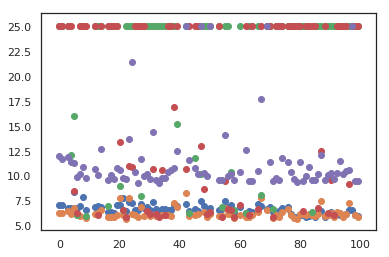

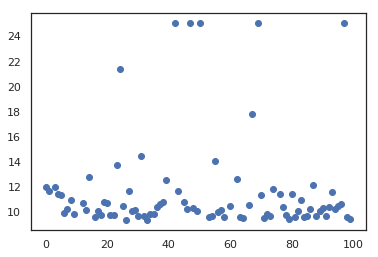

In [6]:
def create_time_drift_plot(dfs):
    for df in dfs:
        plt.scatter(df["index"], df["termination_time"])
    plt.show()
    
    plt.scatter(dfs[-1]["index"], df["termination_time"])
    plt.show()
    
create_time_drift_plot(dfs)

{'Spatial Autoencoder': 'purple', 'Ground truth 2D image coordinate': 'orange', 'Ground truth 3D point': 'red', 'Dense Descriptors': 'green', 'End-to-End': 'blue'}


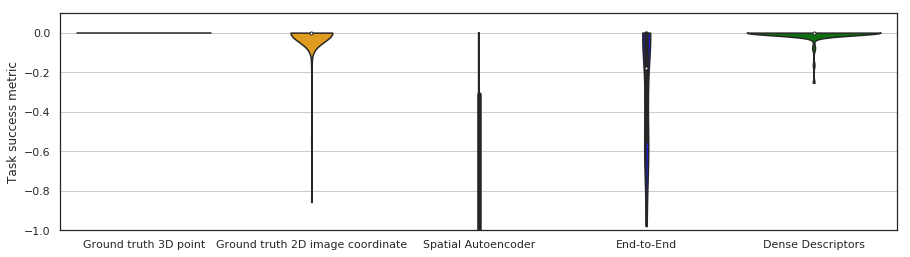

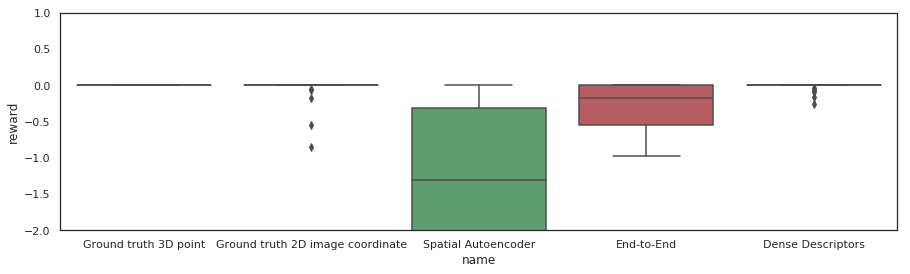

1.0
0.941176470588
0.186046511628
0.43023255814
0.941860465116


In [12]:
import matplotlib

# for this to save beautifully you need:
# sudo apt-get install texlive-full

from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Arial']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
#rc('text', usetex=True)

my_pal = {"Ground truth 3D point": "red", "Ground truth 2D image coordinate": "orange", "Spatial Autoencoder": "purple",
         "End-to-End": "blue", "Dense Descriptors": "green"}

print my_pal

def create_violin_plot(dfs):
    df_all = pd.concat(dfs)
    sns.set(style="white")
    #sns.set_style('axes.grid': True)
    #sns.set_style("darkgrid", {"axes.facecolor": ".9"})
    sns.set_style("white", {"axes.grid": True})
    
    ax = sns.violinplot(x=df_all["name"], y=df_all["reward"], cut=0.0, palette=my_pal)
    ax.set_ylim(-1.0,0.1)
    ax.set_xlabel("")
    ax.set_ylabel('Task success metric')
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(15, 4)
    fig.savefig("MTB-violin-1.0.pdf")
    plt.show()
    
create_violin_plot(dfs)

def create_boxplot(dfs):
    df_all = pd.concat(dfs)
    sns.set(style="white")
    ax = sns.boxplot(x=df_all["name"], y=df_all["reward"])
    ax.set_ylim(-2,1)
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(15, 4)
    plt.show()
    
create_boxplot(dfs)

for df in dfs:
    num_within_threshold = len(df[df["reward"] >= 0.0])
    num_total = len(df)
    print num_within_threshold * 1.0/ num_total


LinAlgError: singular matrix

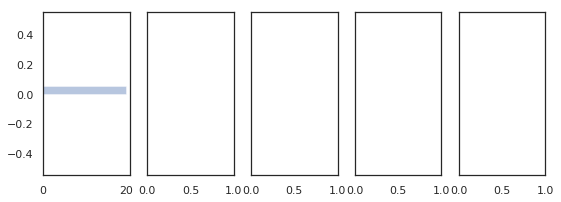

In [8]:
# great example: https://seaborn.pydata.org/examples/distplot_options.html
# full documentation: https://seaborn.pydata.org/generated/seaborn.distplot.html
def create_dist_plot(dfs):
    df_all = pd.concat(dfs)
    
    fig, axes = plt.subplots(1, len(dfs), figsize=(9, 3), sharey=True)
    #axes[0].set_ylim([-20,0])
    sns.set(style="whitegrid")
    for i, df in enumerate(dfs):
        sns.distplot(df["reward"], vertical=True, ax=axes[i], bins=20)
        #ax = sns.violinplot(x=df_all["name"], y=df_all["reward"])
        #fig = matplotlib.pyplot.gcf()
        #fig.set_size_inches(18.5, 10.5)
    plt.show()

    fig, axes = plt.subplots(1, len(dfs), figsize=(9, 3), sharey=True)
    axes[0].set_ylim([-2,-1])
    sns.set(style="whitegrid")
    for i, df in enumerate(dfs):
        sns.distplot(df["reward"], vertical=True, ax=axes[i], bins=20, rug=True)
        #ax = sns.violinplot(x=df_all["name"], y=df_all["reward"])
        #fig = matplotlib.pyplot.gcf()
        #fig.set_size_inches(18.5, 10.5)
    plt.show()

    
    
create_dist_plot(dfs)